In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

In [2]:
from openai import AzureOpenAI
from config import settings
from evaluation.schemas import EvaluationResponse

In [3]:
client = AzureOpenAI(
    azure_endpoint=settings.AZURE_GPT_ENDPOINT,
    api_version="2025-01-01-preview",
    api_key=settings.AZURE_GPT_KEY,
)

In [4]:
import json
import pandas as pd

with open("./synthetic_dataset/synthetic_dataset.json", "r") as f:
    data = json.load(f)

records = []
for item in data:
    chunk = item["chunk"]
    chunk_id = item.get("id")
    cluster_tsne = item.get("cluster_tsne")

    for qa in item["qa_pairs"]:
        record = {
            "id": chunk_id,
            "cluster_tsne": cluster_tsne,
            "question": qa["question"],
            "answer_true": qa["answer_true"],
            "question_type": qa["metadata"]["question_type"],
            "difficulty": qa["metadata"]["difficulty"],
            "required_context": qa["metadata"]["required_context"],
            "reasoning": qa["metadata"]["reasoning"],
            # Include chunk fields, flattening them
            "chunk": chunk,
        }
        records.append(record)

df = pd.DataFrame(records)

df.head()

,id,cluster_tsne,question,answer_true,question_type,difficulty,required_context,reasoning,chunk
0,a127802e-68ba-4a4e-91b5-ad6cf6d54c3b,goods_0,What is the significance of the item listed un...,The item listed under schedule II with serial ...,analytical,medium,Serial number 128 under schedule II.,Examined the item's placement within schedule ...,"{'id': 'a127802e-68ba-4a4e-91b5-ad6cf6d54c3b',..."
1,a127802e-68ba-4a4e-91b5-ad6cf6d54c3b,goods_0,Does the item under serial number 128 list any...,"No, the item under serial number 128 does not ...",factual,easy,Rates listed for serial number 128 under sched...,Verified the document for presence of any GST ...,"{'id': 'a127802e-68ba-4a4e-91b5-ad6cf6d54c3b',..."
2,5b734b1a-d513-45b3-91f2-715fff78bb9f,goods_0,What type of services are typically exempt fro...,Services related to the protection and mainten...,factual,medium,[Omitted],Given the context and the example of services ...,"{'id': '5b734b1a-d513-45b3-91f2-715fff78bb9f',..."
3,5b734b1a-d513-45b3-91f2-715fff78bb9f,goods_0,Analyze which types of services could be class...,Services involving activities such as restorat...,analytical,hard,[Omitted],This requires inference based on the descripti...,"{'id': '5b734b1a-d513-45b3-91f2-715fff78bb9f',..."
4,e3253c9d-deca-461a-b8af-0076784ba657,goods_0,What category of items does entry number 202 i...,Entry number 202 under schedule II includes [O...,factual,medium,Entry number 202 under schedule II.,I checked the description for entry 202 under ...,"{'id': 'e3253c9d-deca-461a-b8af-0076784ba657',..."


In [5]:
from langchain_core.messages import HumanMessage, SystemMessage

from agents.models import models as union_models
from agents.prompts import (
    PROMPT_GENERATE_OR_CORRECT_SQL_STATEMENT_HUMAN,
    PROMPT_GENERATE_OR_CORRECT_SQL_STATEMENT_SYS,
    PROMPT_GENERATE_RESPONSE_FROM_SQL,
    PROMPT_GET_REQUIRED_TABLES,
    PROMPT_GET_THE_CORE_SUBJECT,
    sql_queries_output_parser,
    table_names_output_parser,
)
from agents.utils import convert_rows_to_markdown
from config import settings
from database.connection import PGConnection
from database.utils import get_sample
from retriever.retriever import PGRetriever


chat_models = union_models.copy()


async def get_required_tables(user_query: str, model_name: str) -> dict:
    c = PGConnection(settings.POSTGRES_DSN.unicode_string())
    conn = c.get_conn()
    with conn.cursor() as cur:
        cur.execute("SELECT * FROM description_table;")
        colnames = [desc[0] for desc in cur.description]
        rows = [dict(zip(colnames, row)) for row in cur.fetchall()]
    conn.close()

    markdown_table = convert_rows_to_markdown(rows)
    prompt = PROMPT_GET_REQUIRED_TABLES.format(
        user_query=user_query, table_descriptions=markdown_table
    )
    messages = [HumanMessage(content=prompt)]

    m = chat_models[model_name] | table_names_output_parser
    response = await m.ainvoke(messages)

    return {"all_tables": response["table_names"]}


async def generate_table_query(
    user_query: str,
    all_tables: list[str],
    sql_statements: list[str],
    query_error: str,
    model_name: str,
) -> dict:
    c = PGConnection(settings.POSTGRES_DSN.unicode_string())
    conn = c.get_conn()

    system_msg = PROMPT_GENERATE_OR_CORRECT_SQL_STATEMENT_SYS.format()
    all_tables_samples = "\n\n".join(
        [
            get_sample(cursor=conn.cursor(), table_name=table_name)
            for table_name in all_tables
        ]
    )
    conn.close()

    human_msg = PROMPT_GENERATE_OR_CORRECT_SQL_STATEMENT_HUMAN.format(
        user_query=user_query,
        all_tables=all_tables_samples,
        generated_query="\n".join(sql_statements),
        query_error=query_error,
    )

    messages = [SystemMessage(content=system_msg), HumanMessage(content=human_msg)]
    m = chat_models[model_name] | sql_queries_output_parser
    response = await m.ainvoke(messages)

    return {"sql_statements": response["queries"]}


async def get_core_subject(user_query: str, model_name: str) -> dict:
    prompt = PROMPT_GET_THE_CORE_SUBJECT.format(user_query=user_query)
    messages = [HumanMessage(content=prompt)]
    m = chat_models[model_name]
    response = await m.ainvoke(messages)

    return {"core_subject": response.content}


async def execute_query(
    sql_statements: list[str], user_query: str, core_subject: str
) -> dict:
    retriever = PGRetriever()
    query_text = core_subject if core_subject else user_query
    results = {"result_langchain_docs": [], "query_error": ""}

    try:
        for statement in sql_statements:
            docs = retriever.get_relevant_documents(statement, user_query=query_text)
            results["result_langchain_docs"].extend(docs)
    except Exception as e:
        return {"result_langchain_docs": "", "query_error": f"Error: {e}"}

    return results


async def generate_response(
    user_query: str, result_langchain_docs: list[dict], model_name: str
) -> dict:
    markdown_table = convert_rows_to_markdown(result_langchain_docs)
    prompt = PROMPT_GENERATE_RESPONSE_FROM_SQL.format(
        user_query=user_query, query_results=markdown_table
    )
    messages = [HumanMessage(prompt)]

    m = chat_models[model_name]
    response = await m.ainvoke(messages)

    return {"messages": [response]}

## JUDGE

In [6]:
def generate_judge_prompt(question: str, answer_true: str, answer_rag: str) -> str:
    prompt = f"""
## **SYSTEM INSTRUCTIONS**
* You are an expert evaluator assessing the quality of answers generated by a RAG (Retrieval-Augmented Generation) system. 
* Your task is to compare a generated answer against a reference answer and provide a detailed evaluation.

Question: 
{question}

Reference Answer: 
{answer_true}

Generated Answer: 
{answer_rag}

Please evaluate the generated answer through the following steps:

Step 1: Analyze the factual accuracy by comparing specific claims in the generated answer against 
the reference answer. List which facts are correct and which (if any) are incorrect or misrepresented.

Step 2: Identify any important information from the reference answer that is missing in the 
generated answer.

Step 3: Determine if the generated answer contains any hallucinated information (claims 
not supported by the reference answer).

Step 4: Assess how directly the generated answer addresses the original question.

Based on your analysis, provide scores on a scale of 1-5 for each dimension:

Factual Accuracy (1-5):
1: Contains multiple factual errors
3: Contains minor inaccuracies
5: All facts are completely accurate

Completeness (1-5):
1: Missing most key information
3: Contains core information but omits some details
5: Covers all important information from the reference

Relevance (1-5):
1: Barely addresses the question
3: Addresses the main question but with tangential information
5: Directly and specifically answers the question

Hallucination (1-5):
1: Contains significant made-up information
3: Contains minor details not in the reference
5: No hallucinated content whatsoever

Finally, provide an Overall Score (1-5) that reflects the answer's overall quality, 
and a brief justification for your evaluation.

Overall Score (1-5):
Justification:
""".strip()
    return prompt

In [7]:
def evaluate_answer(
    question: str, answer_true: str, answer_rag: str
) -> EvaluationResponse:
    response = client.beta.chat.completions.parse(
        messages=[
            {
                "role": "user",
                "content": generate_judge_prompt(question, answer_true, answer_rag),
            }
        ],
        model="gpt-4o",
        temperature=0,
        response_format=EvaluationResponse,
    )

    return EvaluationResponse.model_validate_json(
        response.choices[0].message.content.strip()
    )

In [8]:
test_response = evaluate_answer(
    question="What is the capital of France?",
    answer_true="The capital of France is Paris.",
    answer_rag="Paris is the capital of France.",
)

In [9]:
import json

print(json.dumps(test_response.model_dump(), indent=2))

{
  "factual_accuracy": 5,
  "completeness": 5,
  "relevance": 5,
  "hallucination": 5,
  "overall": 5,
  "justification": "The generated answer is factually accurate, complete, directly relevant to the question, and contains no hallucinated information. It correctly identifies Paris as the capital of France, mirroring the reference answer in content and structure. Therefore, it meets all evaluation criteria perfectly."
}


In [ ]:
async def invoke_RAG(user_query: str, model_name: str):
    all_tables = []
    sql_statements = []
    core_subject = ""
    results = {"result_langchain_docs": [], "query_error": ""}
    answer = ""

    all_tables_cou = await get_required_tables(
        user_query=user_query, model_name=model_name
    )
    all_tables = all_tables_cou["all_tables"]

    # Make sure the id is fetched if any records are returned
    for i in range(3):
        try:
            sql_statements_cou = await generate_table_query(
                user_query=user_query,
                all_tables=all_tables,
                sql_statements=sql_statements,
                query_error=results["query_error"],
                model_name=model_name,
            )
            sql_statements = sql_statements_cou["sql_statements"]

            core_subject_cou = await get_core_subject(
                user_query=user_query, model_name=model_name
            )
            core_subject = core_subject_cou["core_subject"]

            results = await execute_query(
                sql_statements=sql_statements,
                user_query=user_query,
                core_subject=core_subject,
            )

            if results["query_error"] == "":
                for i in results["result_langchain_docs"]:
                    if "id" not in i:
                        results["query_error"] = "Error: No id found in the result"
                        raise Exception
                break
        except:
            pass

    answer = await generate_response(
        user_query=user_query,
        result_langchain_docs=results["result_langchain_docs"],
        model_name=model_name,
    )

    if len(results["result_langchain_docs"]) == 0:
        return answer["messages"][0].content, []

    return answer["messages"][0].content, [
        i["id"] for i in results["result_langchain_docs"]
    ]


async def judge_RAG(df, eval_filepath, model_name):
    evaluation_results = json.load(open(eval_filepath, "r"))
    retrieval_rank = []
    for i, item in df.iterrows():
        try:
            ground_truth_id = item["id"]
            question = item["question"]
            answer_true = item["answer_true"]
            answer_rag, retrieved_ids = await invoke_RAG(question, model_name)

            id_rank = None
            if ground_truth_id in retrieved_ids:
                id_rank = retrieved_ids.index(ground_truth_id) + 1
            else:
                id_rank = -1

            evaluation = evaluate_answer(question, answer_true, answer_rag)
            evaluation_dict = evaluation.model_dump()
            evaluation_dict.update(
                {
                    "question": question,
                    "answer_true": answer_true,
                    "answer_rag": answer_rag,
                    "cluster_tsne": item["cluster_tsne"],
                    "retrival_rank": id_rank,
                }
            )

            evaluation_results.append(evaluation_dict)
            retrieval_rank.append(id_rank)

            with open(eval_filepath, "w", encoding="utf-8") as eval_file:
                json.dump(evaluation_results, eval_file, indent=2, ensure_ascii=False)

            print(f"Generated for {i + 1}")

        except Exception as e:
            print(f"Failed for {i + 1}")
            retrieval_rank.append(-1)

    df["retrieval_rank"] = retrieval_rank
    return df

In [11]:
eval_path = "./evaluation_results/rag_evaluation.json"
evaluated_df = await judge_RAG(df, eval_path, "azure-gpt-4o")
evaluated_df

Generated for 1
Generated for 2
Generated for 3
Generated for 4
Generated for 5
Generated for 6
Generated for 7
Generated for 8
Generated for 9
Generated for 10
Generated for 11
Generated for 12
Generated for 13
Generated for 14
Generated for 15
Generated for 16
Generated for 17
Generated for 18
Generated for 19
Generated for 20
Generated for 21
Generated for 22
Generated for 23
Generated for 24
Generated for 25
Generated for 26
Generated for 27
Generated for 28
Generated for 29
Generated for 30
Generated for 31
Generated for 32
Generated for 33
Generated for 34
Generated for 35
Generated for 36
Generated for 37
Generated for 38
Generated for 39
Generated for 40
Generated for 41
Generated for 42
Generated for 43
Generated for 44
Generated for 45
Generated for 46
Generated for 47
Generated for 48
Generated for 49
Generated for 50
Generated for 51
Generated for 52
Generated for 53
Generated for 54
Generated for 55
Generated for 56
Generated for 57
Generated for 58
Generated for 59
Genera

,id,cluster_tsne,question,answer_true,question_type,difficulty,required_context,reasoning,chunk,retrieval_rank
0,a127802e-68ba-4a4e-91b5-ad6cf6d54c3b,goods_0,What is the significance of the item listed un...,The item listed under schedule II with serial ...,analytical,medium,Serial number 128 under schedule II.,Examined the item's placement within schedule ...,"{'id': 'a127802e-68ba-4a4e-91b5-ad6cf6d54c3b',...",1
1,a127802e-68ba-4a4e-91b5-ad6cf6d54c3b,goods_0,Does the item under serial number 128 list any...,"No, the item under serial number 128 does not ...",factual,easy,Rates listed for serial number 128 under sched...,Verified the document for presence of any GST ...,"{'id': 'a127802e-68ba-4a4e-91b5-ad6cf6d54c3b',...",2
2,5b734b1a-d513-45b3-91f2-715fff78bb9f,goods_0,What type of services are typically exempt fro...,Services related to the protection and mainten...,factual,medium,[Omitted],Given the context and the example of services ...,"{'id': '5b734b1a-d513-45b3-91f2-715fff78bb9f',...",-1
3,5b734b1a-d513-45b3-91f2-715fff78bb9f,goods_0,Analyze which types of services could be class...,Services involving activities such as restorat...,analytical,hard,[Omitted],This requires inference based on the descripti...,"{'id': '5b734b1a-d513-45b3-91f2-715fff78bb9f',...",-1
4,e3253c9d-deca-461a-b8af-0076784ba657,goods_0,What category of items does entry number 202 i...,Entry number 202 under schedule II includes [O...,factual,medium,Entry number 202 under schedule II.,I checked the description for entry 202 under ...,"{'id': 'e3253c9d-deca-461a-b8af-0076784ba657',...",1
...,...,...,...,...,...,...,...,...,...,...
595,76ed3540-cb3b-4390-8fbf-54f2031c7e6a,services_14,Are the services related to rice under Heading...,The services related to rice under Heading 996...,analytical,medium,"""cgst_rate"": null, ""sgst_utgst_rate"": null, ""i...",The question requires inferring whether tax ra...,"{'id': '76ed3540-cb3b-4390-8fbf-54f2031c7e6a',...",-1
596,5c235fcf-76be-49a5-a519-1b0e1bf4445a,services_14,What does the description for chapter heading ...,"Under heading 9973, leasing or rental services...",analytical,medium,"""Any transfer of right in goods or of undivide...",The description specifies the technical aspect...,"{'id': '5c235fcf-76be-49a5-a519-1b0e1bf4445a',...",-1
597,5c235fcf-76be-49a5-a519-1b0e1bf4445a,services_14,Are there any specified GST rates for services...,There are no specified GST rates for services ...,factual,easy,"""cgst_rate"": null, ""sgst_utgst_rate"": null, ""i...",The question directly asks about the documente...,"{'id': '5c235fcf-76be-49a5-a519-1b0e1bf4445a',...",-1
598,b9f6ea41-0856-4e12-b1c9-e762fb7fd22d,services_14,What type of transfer is described under headi...,"Under heading 9971, it describes 'Any transfer...",factual,easy,(iii) Any transfer of right in goods or of und...,The question directly asks for the description...,"{'id': 'b9f6ea41-0856-4e12-b1c9-e762fb7fd22d',...",-1


In [4]:
import pandas as pd

eval_path = "./evaluation_results/rag_evaluation.json"
evaluated_df = pd.read_json(eval_path, orient="records")

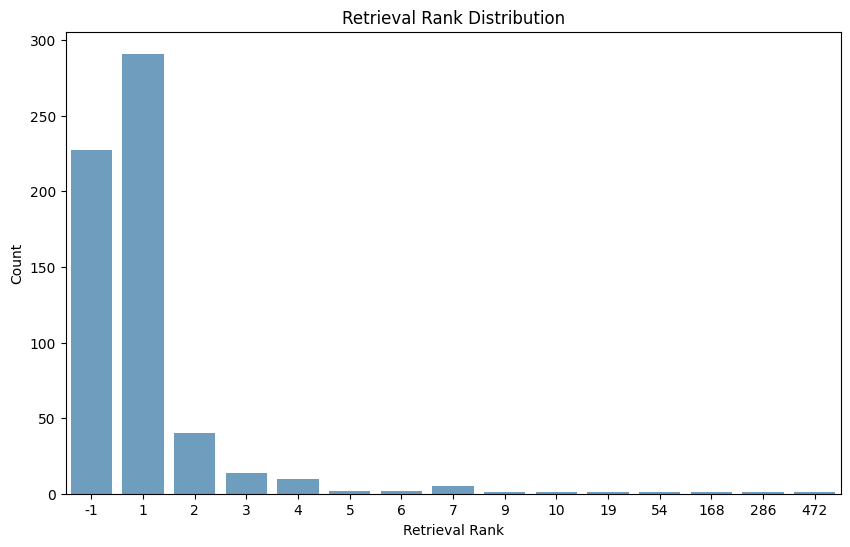

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

rank_counts = evaluated_df.retrival_rank.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=rank_counts.index.astype(str), y=rank_counts.values, alpha=0.7)
plt.title("Retrieval Rank Distribution")
plt.xlabel("Retrieval Rank")
plt.ylabel("Count")
plt.show()

In [6]:
# Which clusters have the most failed retrievals
evaluated_df.query("retrival_rank == -1").groupby("cluster_tsne")[
    "retrival_rank"
].count().sort_values(ascending=False).head(10)

cluster_tsne
services_14    9
services_10    9
goods_25       9
goods_24       8
services_3     8
goods_6        8
goods_26       8
goods_0        7
goods_10       7
services_5     7
Name: retrival_rank, dtype: int64

In [ ]:
# print chunks of services_14
services_14 = df.query("cluster_tsne == 'services_14'")["chunk"].to_list()
questions = evaluated_df.query("cluster_tsne == 'services_14'")["question"].to_list()
answers_true = evaluated_df.query("cluster_tsne == 'services_14'")["answer_true"].to_list()
answers_rag = evaluated_df.query("cluster_tsne == 'services_14'")["answer_rag"].to_list()
overall = evaluated_df.query("cluster_tsne == 'services_14'")["overall"].to_list()
justification = evaluated_df.query("cluster_tsne == 'services_14'")["justification"].to_list()

view = []
for i in range(len(services_14)):
    view.append({
        "question": questions[i],
        "chunk": services_14[i],
        "answer_true": answers_true[i],
        "answer_rag": answers_rag[i],
        "overall": overall[i],
        "justification": justification[i],
    })

for i in view:
    print(json.dumps(i, indent=2, ensure_ascii=False))

{
  "question": "What type of services are provided under Heading 9988 regarding fruits and vegetables?",
  "chunk": {
    "id": "2cb59676-957a-453b-8258-910d784f80c9",
    "s_no": null,
    "chapter_section_heading": "Heading 9988  or any other Heading of Section 8 and Section 9",
    "usevec_description": "Services by way of pre-conditioning, pre-cooling, ripening, waxing, retail packing, labelling of fruits and vegetables which do not change or alter the essential characteristics of the said fruits or vegetables.",
    "cgst_rate": null,
    "sgst_utgst_rate": null,
    "igst_rate": null,
    "condition": "…",
    "cluster_kmeans": 13,
    "cluster_tsne": 14
  },
  "answer_true": "The services provided under Heading 9988 include pre-conditioning, pre-cooling, ripening, waxing, retail packing, and labeling of fruits and vegetables, ensuring their essential characteristics remain unchanged.",
  "answer_rag": "The query did not return any results, so there is no information available r

In [ ]:
# Which clusters have the most successful retrievals
evaluated_df.query("retrival_rank > 0").groupby("cluster_tsne")[
    "retrival_rank"
].count().sort_values(ascending=False).head(20)

cluster_tsne
goods_9        11
goods_33       11
goods_2        11
goods_29       10
goods_21       10
goods_30       10
goods_13       10
goods_4        10
goods_34       10
goods_1        10
goods_19       10
goods_22       10
services_12     9
goods_23        9
services_0      9
goods_20        9
services_7      9
goods_5         9
goods_8         9
goods_18        9
Name: retrival_rank, dtype: int64

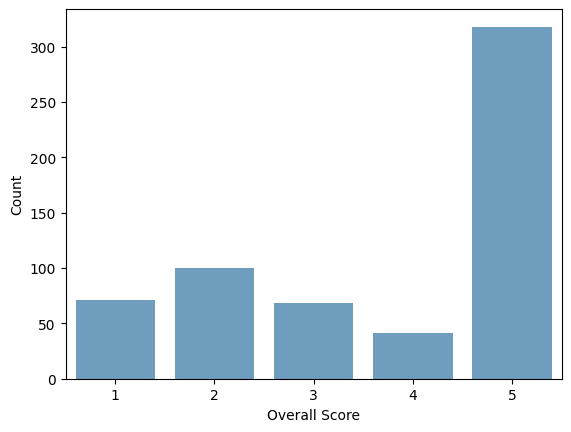

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rank_counts = evaluated_df.overall.value_counts().sort_index()

# Plot the distribution of overall scores
sns.barplot(x=rank_counts.index.astype(str), y=rank_counts.values, alpha=0.7)
plt.xlabel("Overall Score")
plt.ylabel("Count")
plt.show()

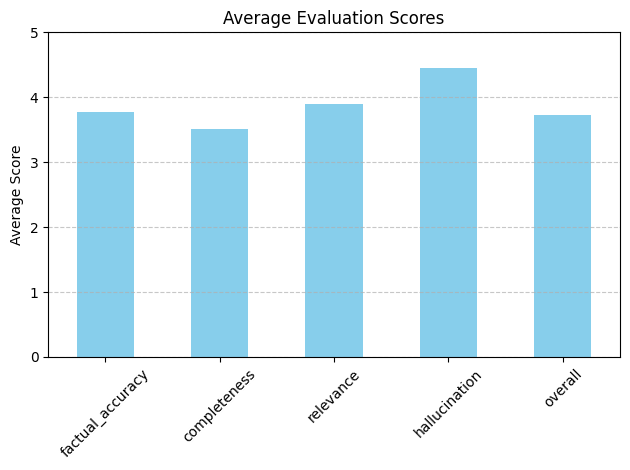

In [7]:
import matplotlib.pyplot as plt

cols = ["factual_accuracy", "completeness", "relevance", "hallucination", "overall"]

column_means = evaluated_df[cols].mean()

# Plot the average evaluation scores
column_means.plot(kind="bar", color="skyblue")
plt.title("Average Evaluation Scores")
plt.ylabel("Average Score")
plt.ylim(0, 5)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Working 50% of the time due to multiple tables in the database
# Will need to be fixed